In [188]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

In [189]:
season_code = "25_26"

current_dir = Path.cwd()  
path_folder = current_dir.parent.parent.parent / "csv" / f"csv{season_code}" / "players"
path_start  = os.path.join(path_folder, "clean/data_goals.csv")
path_end    = os.path.join(path_folder, "ratings/data_goals.csv")
path_end_avg    = os.path.join(path_folder, "ratings/data_goals_average.csv")

path_notes = current_dir.parent.parent.parent / "csv" / f"csv24_25" / "players" / "clean" / "data_goals.csv"

In [190]:
data = pd.read_csv(path_start, index_col=0)
note_max = 10

In [191]:
def rating_league(raw_note, league):
    league_weights = {
        "UEFA Champions League": 1.3,
        "French Ligue 1": 1.0,
        "German Bundesliga": 1.0,
        "Italian Serie A": 1.0,
        "Spanish La Liga": 1.1,
        "English Premier League": 1.1,
        "UEFA Europa League": 1.0,
        "UEFA Europa Conference League": 0.9
    }
    
    raw_note *= league_weights.get(league, 1.0)
    
    return round(raw_note, 2)

In [192]:
def rescale_rating(df, col="Rating", mean=5.5, std=2.5, note_max=100):
    mean = mean*note_max/10
    std = std*note_max/10
    n = len(df)
    
    ratings_gauss = np.random.normal(loc=mean, scale=std, size=n)
    
    order = df[col].rank(method="first")
    ratings_gauss_sorted = np.sort(ratings_gauss)
    df[col] = [ratings_gauss_sorted[int(r-1)] for r in order]
    
    return df

In [193]:
def get_position_indices():
    indices_comp = [
        'Goals Against',              
        'Save Efficiency',           
        'Saves',                     
        'Completed Long Passes',      
        'Crosses Stopped',            
        'Defensive Actions Outside Penalty Area'
    ]
    
    indices_neg = [
        'Goals Against'
    ]  
    
    coeff_indices = [0, 5, 2, 2, 1, 1]  

    return indices_comp, indices_neg, coeff_indices

In [194]:
def data_by_position(data):
    results = {}
    indices, _, _ = get_position_indices()
        
    results_position = data[indices].copy()
    results_position = results_position[indices]
    results_position.index = data.index
    results = {stat: results_position[stat].dropna().iloc[:, 0].tolist() if isinstance(results_position[stat], pd.DataFrame) else results_position[stat].dropna().tolist() for stat in indices}

    return results

In [195]:
def notation(data, note_max):
    results = []
    
    indices, negative_indices, weights = get_position_indices()
    
    data_notes = pd.read_csv(path_notes, index_col=0)
    data_stats = data_by_position(data_notes)
    #data_stats = data_by_position(data)

    for idx, row in data.iterrows():
        minutes = row['Minutes']
        if minutes <= 0 or pd.isnull(minutes):
            continue

        game_week = row['Game Week']
        position = row.get('Position')
        gen_position = row.get('General Position')
        team = row['Team']
        league = row['League']
        age = row['Age']
        nation = row['Nationality']

        centiles = {}
        factor = 90 / minutes
        
        for stat, coeff in zip(indices, weights):
            if pd.isnull(row[stat]):
                continue

            player_value = row[stat] * factor

            all_values = np.array(data_stats[stat])  

            if len(all_values) < 3:
                continue 

            if stat in negative_indices:
                centile = (all_values >= player_value).sum() / len(all_values)
            else:
                centile = (all_values <= player_value).sum() / len(all_values)

            centiles[stat] = centile

        if not centiles:
            continue

        raw_note = note_max * sum(centiles[stat] * coeff for stat, coeff in zip(indices, weights) if stat in centiles) / sum(weights)

        raw_note = raw_note * (1 + 0.05*row.get('Clean Sheets', 0))

        #rating = rating_league(raw_note, league)
        rating = raw_note
        rating = min(max(rating, 0), note_max)
        
        results.append({
            "Player": idx,
            "Game Week": game_week,
            "Position": position,
            "General Position": gen_position,
            "Team": team,
            "League": league,
            "Minutes": minutes,
            "Rating": rating, 
            "Age": age,
            "Nationality": nation
        })
        
    results = pd.DataFrame(results)
    #results = results.groupby("Position").apply(rescale_rating).reset_index(drop=True)
    results["Rating"] = results["Rating"].round(2)
    
    return pd.DataFrame(results)


In [196]:
notes = notation(data, note_max)

In [197]:
notes.to_csv(path_end, index=False)

In [198]:
notes.head()

,Player,Game Week,Position,General Position,Team,League,Minutes,Rating,Age,Nationality
0,Stefano Turati,J1,GK,Goalkeeper,Sassuolo,Italian Serie A,90,3.07,23,ITA
1,Alex Meret,J1,GK,Goalkeeper,Napoli,Italian Serie A,90,5.37,28,ITA
2,Yann Sommer,J1,GK,Goalkeeper,Inter,Italian Serie A,90,7.93,36,SUI
3,Franco Israel,J1,GK,Goalkeeper,Torino,Italian Serie A,90,3.85,25,URU
4,Ivan Provedel,J10,GK,Goalkeeper,Lazio,Italian Serie A,90,8.23,31,ITA


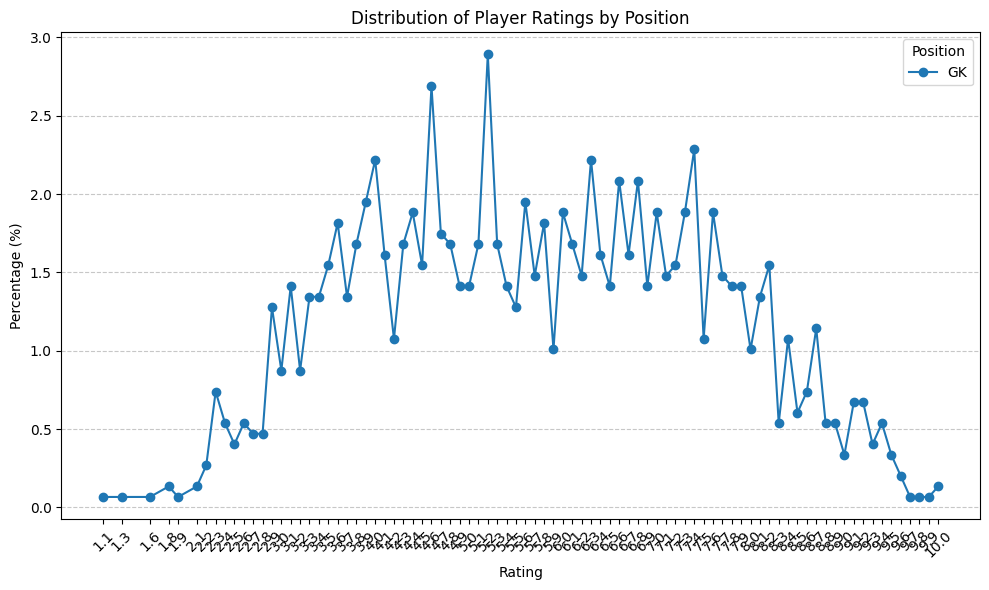

In [199]:
notes["Rating_rounded"] = notes["Rating"].round(1)

positions = notes["Position"].dropna().unique()

plt.figure(figsize=(10, 6))

for pos in sorted(positions):
    subset = notes[notes["Position"] == pos]
    dist = subset["Rating_rounded"].value_counts(normalize=True).sort_index() * 100
    plt.plot(dist.index, dist.values, marker='o', label=pos)

plt.xlabel("Rating")
plt.ylabel("Percentage (%)")
plt.title("Distribution of Player Ratings by Position")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(sorted(notes["Rating_rounded"].unique()), rotation=45)
plt.legend(title="Position")
plt.tight_layout()
plt.show()

In [200]:
def get_average_scores(df):
    df = df.dropna(subset=['Rating', 'Minutes'])
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Minutes'] = pd.to_numeric(df['Minutes'], errors='coerce')
    df = df[df['Minutes'] > 0]

    df["Matches"] = 1 
    
    grouped = df.groupby(["Player", "Age"]).agg({
        "Rating": 'sum',
        "Minutes": 'sum',
        "Matches": 'sum',
        "Team": lambda x: ', '.join(sorted(set(x))),
        "League": lambda x: ', '.join(sorted(set(x))),
        "Position": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        "General Position": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        "Nationality": "first"
    }).reset_index()

    return grouped

In [201]:
def merge_similar_players(df, max_age_diff=1):
    df = df.sort_values(by=["Player", "Age"]).reset_index(drop=True)
    merged_rows = []
    used_indices = set()

    for i, row_i in df.iterrows():
        if i in used_indices:
            continue
        mask = (
            (df["Player"] == row_i["Player"]) &
            (df["Nationality"] == row_i["Nationality"]) &
            (abs(df["Age"] - row_i["Age"]) <= max_age_diff)
        )
        close_rows = df[mask]
        indices = close_rows.index.tolist()
        used_indices.update(indices)
        subset = df.loc[indices]
        new_row = {}
        new_row["Player"] = row_i["Player"]
        teams = subset["Team"].dropna().apply(lambda x: [t.strip() for t in str(x).split(',')])
        flat_teams = [team for sublist in teams for team in sublist]
        new_row["Team"] = ', '.join(sorted(set(flat_teams)))
        
        leagues = set()
        for league_entry in subset["League"]:
            if isinstance(league_entry, list):
                leagues.update(league_entry)
            elif isinstance(league_entry, str) and league_entry.startswith("["): 
                try:
                    import ast
                    leagues.update(ast.literal_eval(league_entry))
                except:
                    leagues.add(league_entry)
            elif isinstance(league_entry, str):
                leagues.update([l.strip() for l in league_entry.split(",") if l.strip()])
            else:
                leagues.add(league_entry)
        new_row["League"] = ', '.join(sorted(leagues))

        for col in ["Position", "General Position", "Nationality"]:
            if col in subset.columns and not subset[col].mode().empty:
                new_row[col] = subset[col].mode().iloc[0]
            else:
                new_row[col] = None

        new_row["Age"] = int(subset["Age"].max())

        for col in ["Rating", "Minutes", "Matches"]:
            new_row[col] = subset[col].sum()

        new_row["Average Rating"] = round(new_row["Rating"] / new_row["Matches"], 2)  if new_row["Matches"] > 0 else None

        merged_rows.append(pd.Series(new_row))

    df_merged = pd.DataFrame(merged_rows).round(2) #.round(2)

    for col in ["Minutes", "Age"]:
        if col in df_merged.columns:
            df_merged[col] = df_merged[col].astype("Int64")

    return df_merged

In [202]:
data = pd.read_csv(path_end, index_col=0)
data_bis = get_average_scores(data)
data_avg = merge_similar_players(data_bis, max_age_diff=1)
data_avg.to_csv(path_end_avg, index=False)

In [203]:
data_avg.head()

,Player,Team,League,Position,General Position,Nationality,Age,Rating,Minutes,Matches,Average Rating
0,Aaron Ramsdale,Newcastle Utd,English Premier League,GK,Goalkeeper,ENG,27,2.71,14,1,2.71
1,Aarón Escandell,Oviedo,Spanish La Liga,GK,Goalkeeper,ESP,30,81.36,1080,12,6.78
2,Adrian Šemper,Pisa,Italian Serie A,GK,Goalkeeper,CRO,27,64.85,990,11,5.90
3,Alban Lafont,Panathinaikos,UEFA Europa League,GK,Goalkeeper,FRA,26,16.30,270,3,5.43
4,Alberto Paleari,Torino,Italian Serie A,GK,Goalkeeper,ITA,33,27.41,360,4,6.85
